# Analysis on Hadron Multiplicity Networks
1. Data Summary & Visualization
2. Classification between Broken and Healthy Networks
3. Regression on Healthy Networks

## Data Summary & Visualization

In [2]:
#Data processing
import numpy as np
import pandas as pd
from sklearn import preprocessing
import plotly.plotly as py
import plotly.figure_factory as ff
from sklearn.preprocessing import PolynomialFeatures

#Plotting
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns; sns.set()

#Analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn import cluster
from sklearn import manifold
from scipy import stats

#Machine Learning Model
#Common Model Algorithms
import statsmodels.api as sm
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier, RandomTreesEmbedding
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
#For xgboost
import xgboost as xgb

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import random_projection

#Model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [9]:
df = pd.read_csv("/Users/duc_hoang/Box Sync/Fermilab Summer Research/Analysis_Scripts/Main data-hadron multiplicity/Hadron_multiplicity_features.csv",
                  index_col = 0)

In [10]:
#Drop nan value
df = df.dropna()

print("Shape after dropping nan: ", df.shape)

Shape after dropping nan:  (158632, 35)


In [11]:
df1 = df[df['final_accuracy'] > 0.375]

print("Selected accuracy shape: ", df1.shape)

Selected accuracy shape:  (17307, 35)


Text(0.5, 0, 'Accuracy')

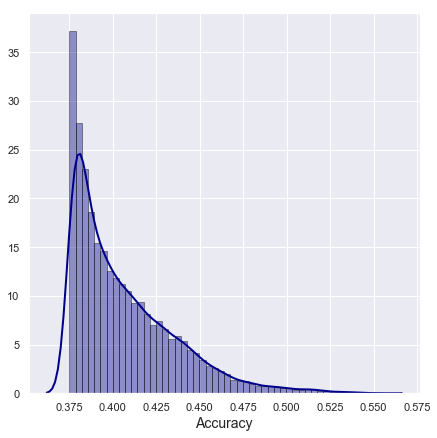

In [15]:
#histogram for selected accuracy
fig = plt.figure(figsize=[7,7])
fig1 = sns.distplot(df1["final_accuracy"],
                    hist=True, kde=True, 
                    color = 'darkblue',
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth': 2}, norm_hist=True);
fig1.set_xlabel("Accuracy", fontsize = 14)

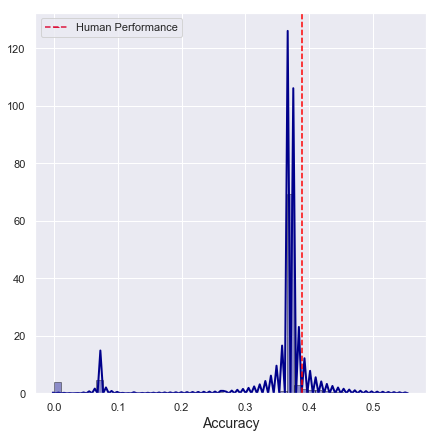

In [17]:
# Histogram for all accuracy
# Histogram for selected accuracy
fig = plt.figure(figsize=[7,7])

fig1 = sns.distplot(df["final_accuracy"],
                    hist=True, kde=True, 
                    color = 'darkblue',
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth': 2}, norm_hist=True);

fig1.set_xlabel("Accuracy", fontsize = 14)
plt.axvline(x=0.389, ls = "--", c = "red")
# Manually add legend
human_accuracy = mlines.Line2D([], [], color='crimson', marker='_', linestyle='--',
                                    markersize=6, label='Human Performance', alpha = 1)

plt.legend(handles=[human_accuracy])

## Classification between Broken and Healthy Networks

In [18]:
#Since there are ~17k of Healthy networks, randomly select 17k of broken networks to do classification tasks.

#Healthy
df_healthy = df[df['final_accuracy'] > 0.375]
#Broken
df_broken  = df[df['final_accuracy'] <= 0.375]

In [19]:
print("Number of all networks analysed: ", df.shape[0])
print("Number of Healthy Networks: ", df_healthy.shape[0])
print("Percentage Healthy: ", df_healthy.shape[0]/df.shape[0])
print("Number of Broken Networks: ", df_broken.shape[0])
print("Percentage Broken: ", df_broken.shape[0]/df.shape[0])

Number of all networks analysed:  158632
Number of Healthy Networks:  17307
Percentage Healthy:  0.10910156840990469
Number of Broken Networks:  141325
Percentage Broken:  0.8908984315900953


In [21]:
#Select out 17k networks as in healthy networks
sampled_df_broken = df_broken.sample(n = df_healthy.shape[0], random_state = 0)

In [22]:
#Merge into one
classification_df = pd.concat([sampled_df_broken, df_healthy])

In [23]:
#Select the features and dependent variable
X = classification_df.drop(columns=['initial_accuracy','final_accuracy', 'genealogy']) #Features
y = pd.Series([1 if x > 0.375 else 0 for x in classification_df['final_accuracy']]) #dependent variable

In [24]:
print("X shape: ", X.shape)
print("y shape: ", y.shape)

X shape:  (34614, 32)
y shape:  (34614,)


In [25]:
#Divide train and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=0)

In [26]:
#Scale the inputs
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [27]:
#Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth = 17, min_samples_split=3,
                            bootstrap = False, warm_start = True, random_state=0)

rf.fit(X_train, y_train)

print("Accuracy : %f" % rf.score(X_test, y_test))

Accuracy : 0.705908


In [28]:
print("Cross-validation score on train set: ", np.average(cross_val_score(rf, X_train, y_train, cv = 5)))

Cross-validation score on train set:  0.702610635598743


In [29]:
#Extra Tree Classifier
ext = ExtraTreesClassifier(n_estimators=200, max_depth=20, 
                           min_samples_split=2, bootstrap = False, 
                            warm_start = True, random_state=0)
ext.fit(X_train, y_train)

print("Accuracy : %f" % ext.score(X_test, y_test))

Accuracy : 0.705475


In [30]:
print("Cross-validation score on train set: ", np.average(cross_val_score(ext, X_train, y_train, cv = 5)))

Cross-validation score on train set:  0.7020331552272794


In [ ]:
#Extract important features in two models


## Regression on Healthy Networks

Text(0.5, 1.0, 'Transformed Accuracy')

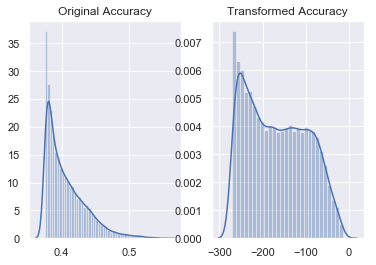

In [123]:
# normalize the exponential data with boxcox
normalized_accuracy = stats.boxcox(df_healthy["final_accuracy"])

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(df_healthy['final_accuracy'], ax=ax[0])
ax[0].set_title("Original Accuracy")
ax[0].set(xlabel='')
sns.distplot(normalized_accuracy[0], ax=ax[1])
ax[1].set_title("Transformed Accuracy")

In [124]:
df_healthy["transformed_accuracy"] = normalized_accuracy[0]

In [139]:
#Feature + target
X_reg = df_healthy.drop(columns=['initial_accuracy','final_accuracy', 'genealogy',"transformed_accuracy"]) #Features
y_reg = df_healthy["transformed_accuracy"]

#Extract initial feature names and index for later use
initial_feature_names = X_reg.columns #Save the feature names
initial_index = X_reg.index

In [140]:
#Scale the inputs
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X_reg)  
X_reg = scaler.transform(X_reg) 

In [141]:
poly = PolynomialFeatures(degree = 3, include_bias = False)
X_reg = poly.fit_transform(X_reg) #Create interaction terms 

In [142]:
#Fit model
model = sm.OLS(y_reg, X_reg)

results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     transformed_accuracy   R-squared:                       0.481
Model:                              OLS   Adj. R-squared:                  0.243
Method:                   Least Squares   F-statistic:                     2.017
Date:                  Mon, 15 Jul 2019   Prob (F-statistic):          1.77e-216
Time:                          14:03:42   Log-Likelihood:                -92337.
No. Observations:                 17307   AIC:                         1.956e+05
Df Residuals:                     11852   BIC:                         2.379e+05
Df Model:                          5454                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            15.6034      6.019      2.592      0.010       3.804      27.402
x2           -17.7672      5.390     -3.296      0.001     -28.332      -7.202
x3           -14.5278      5.730     -2.535      0.011     -25.760      -3.295
x4           -17.6637      5.602     -3.153      0.002     -28.645      -6.682
x5            -0.3567      2.924     -0.122      0.903      -6.089       5.375
const       6.286e-11    4.1e-11      1.531      0.126   -1.76e-11    1.43e-10
x6            53.0171     11.125      4.766      0.000      31.211      74.823
x7            18.8024      6.085      3.090      0.002       6.875      30.730
x8             9.8734      5.617      1.758      0.079      -1.137      20.884
x9            -3.5068      2.492     -1.407      0.159      -8.392       1.379
x10            1.4471      3.533      0.410      0.682      -5.477       8.372
x11           -0.1246      2.815     -0.044      0.965      -5.643       5.394
x12            2.2152      2.441      0.908      0.364      -2.569       6.999
x13            2.3286      2.661      0.875      0.382      -2.887       7.545
x14           15.1255      3.740      4.044      0.000       7.794      22.457
x15           16.8302      2.219      7.585      0.000      12.481      21.179
x16            0.4661      7.823      0.060      0.952     -14.868      15.800
x17            0.1224      6.841      0.018      0.986     -13.286      13.531
x18            0.8298      5.137      0.162      0.872      -9.240      10.899
x19            0.5490      3.956      0.139      0.890      -7.206       8.304
x20            1.8798      3.399      0.553      0.580      -4.783       8.543
x21           -5.5443      4.050     -1.369      0.171     -13.482       2.394
x22           -2.7507      2.559     -1.075      0.282      -7.766       2.265
x23           -1.6623      2.870     -0.579      0.562      -7.288       3.963
x24            3.3427      4.277      0.781      0.435      -5.042      11.727
x25           -9.2404      4.760     -1.941      0.052     -18.571       0.090
x26            4.6967      6.964      0.674      0.500      -8.955      18.348
x27           -7.7995      4.116     -1.895      0.058     -15.867       0.268
x28          -10.7260      5.451     -1.968      0.049     -21.410      -0.042
x29           -0.3516      4.271     -0.082      0.934      -8.723       8.020
x30           -0.9287      2.212     -0.420      0.675      -5.265       3.408
x31           -3.2783      2.647     -1.239      0.215      -8.466       1.910
x32           18.2329     85.341      0.214      0.831    -149.050     185.515
x33           -5.9048    116.384     -0.051      0.960    -234.037     222.228
x34          -29.7844    102.088     -0.292      0.770    -229.893     170.324
x35           53.1181     32.783      1.620      0.105     